# MNIST CLASSIFICATION

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Fetch dataset

In [2]:
import numpy as np
import mnist

In [3]:
train_images = mnist.train_images()
test_images = mnist.test_images()
train_labels = mnist.train_labels()
test_labels = mnist.test_labels()

In [4]:
X = np.vstack((train_images, test_images))
y = np.hstack((train_labels, test_labels))

X = X.reshape(X.shape[0],-1)

#### See data sample

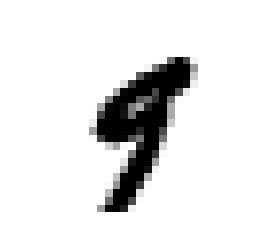

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
y[36000]

9

#### Prepare data sets

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary Classifier

In [9]:
y_train_9 = (y_train == 9)
y_test_9 = (y_test == 9)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_9)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([False])

## Cross-Validation

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_9):
    clone_cfl = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_9[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_9[test_index]
    
    clone_cfl.fit(X_train_folds, y_train_folds)
    y_pred = clone_cfl.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.89
0.9321
0.93005


In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_9, cv=3, scoring="accuracy")

array([0.89   , 0.9321 , 0.93005])

## Confusion Matrix

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_9, y_train_pred)

array([[49855,  4196],
       [  761,  5188]])

In [16]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_9, y_train_pred))
print(recall_score(y_train_9, y_train_pred))

0.5528559249786871
0.8720793410657254


In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_9, y_train_pred)

0.6767103632687668

In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3, method="decision_function")

### Precision vs Recall curve

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_9, y_scores)

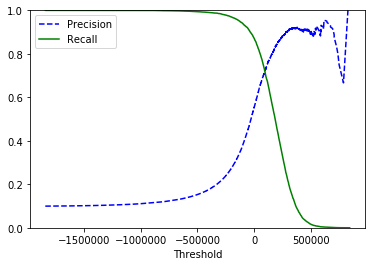

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### RoC curve

In [22]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_9, y_scores)

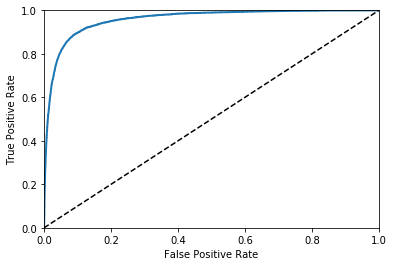

In [23]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

### ROC AUC

In [24]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_9, y_scores)

0.9581142958379469

## Compare with RandomForestClassifier

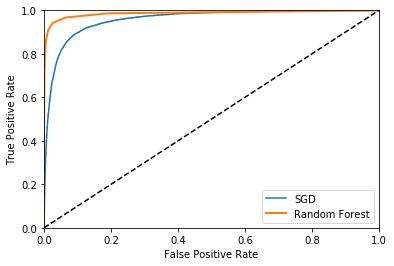

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, -1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_9, y_scores_forest)

plt.plot(fpr, tpr, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

In [28]:
roc_auc_score(y_train_9, y_scores_forest)

0.9867153942340288